# 🎬 FIXED Hybrid VAE Recommendation System - Cloud Training

This notebook trains a Hybrid VAE recommendation model with **CRITICAL FIXES** to improve RMSE from 1.21 → 0.85-0.95

## 🔧 Key Fixes Applied:
1. ✅ **MSE loss uses 'mean' instead of 'sum' reduction** (CRITICAL FIX)
2. ✅ **KL weight reduced from 1.0 → 0.1**
3. ✅ **Learning rate increased from 1e-4 → 5e-4**
4. ✅ **Dropout reduced from 0.3 → 0.15**
5. ✅ **Better weight initialization and scheduler**

---

## ⚙️ Setup Instructions
1. **Runtime**: Change runtime to GPU (Runtime → Change runtime type → GPU)
2. **Data**: Upload your pre-split data files to Colab
3. **Libraries**: Run the installation cell below
4. **Training**: Configure parameters and run training

In [ ]:
# 📦 Install required packages
!pip install wandb -q

# Check GPU availability
import torch
print(f"🚀 PyTorch version: {torch.__version__}")
print(f"🎯 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  No GPU detected - training will be slower")

🚀 PyTorch version: 2.6.0+cu124
🎯 CUDA available: True
🔥 GPU: NVIDIA A100-SXM4-40GB
💾 GPU Memory: 42.5 GB


In [ ]:
# 📚 Import libraries
import os
import sys
import time
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Optional: wandb for experiment tracking
try:
    import wandb
    WANDB_AVAILABLE = True
    print("✅ wandb available for experiment tracking")
except ImportError:
    WANDB_AVAILABLE = False
    print("ℹ️  wandb not available - training metrics won't be logged")

✅ wandb available for experiment tracking


In [ ]:
# 🎲 Set random seeds for reproducibility
def set_random_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🎲 Random seed set to {seed}")

# Set seed immediately
set_random_seed(42)

🎲 Random seed set to 42


## 📁 Data Upload

Upload your pre-split training data files. You need:
- `train_data.csv`
- `val_data.csv`
- `data_mappings.pkl`

**Option 1: Upload files manually**
1. Click the folder icon in the sidebar
2. Upload the three files above

**Option 2: Mount Google Drive** (if files are in Drive)
Uncomment and run the cell below:

In [ ]:
# 💾 Option 2: Mount Google Drive (uncomment if needed)
# from google.colab import drive
# drive.mount('/content/drive')
#
# # Update data_path to point to your Drive folder
data_path = '/content/drive/MyDrive/PROJECTS/MovieLens RecSys'  # Update this path

In [ ]:
# 🔍 Check uploaded files
print("🔍 Checking uploaded files...")

required_files = ['train_data.csv', 'val_data.csv', 'data_mappings.pkl']
missing_files = []

for file in required_files:
    file_path = os.path.join(data_path, file)
    if os.path.exists(file_path):
        size = os.path.getsize(file_path) / 1e6  # MB
        print(f"✅ {file} ({size:.1f} MB)")
    else:
        print(f"❌ {file} - NOT FOUND")
        missing_files.append(file)

if missing_files:
    print(f"\n⚠️  Please upload missing files: {missing_files}")
else:
    print(f"\n🎉 All required files found in {data_path}")

🔍 Checking uploaded files...
✅ train_data.csv (319.1 MB)
✅ val_data.csv (79.8 MB)
✅ data_mappings.pkl (6.6 MB)

🎉 All required files found in /content/drive/MyDrive/PROJECTS/MovieLens RecSys


## 🧠 Model Definition

Hybrid VAE + Embedding architecture for collaborative filtering

In [ ]:
class HybridVAE(nn.Module):
    """FIXED Hybrid VAE + Embedding model for recommendation"""
    def __init__(self, n_users, n_movies, n_factors=150,
                 hidden_dims=[512, 256, 128], latent_dim=64,
                 dropout_rate=0.15):  # FIXED: Reduced default dropout
        super(HybridVAE, self).__init__()

        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.movie_embedding = nn.Embedding(n_movies, n_factors)
        self.embedding_dropout = nn.Dropout(dropout_rate * 0.5)

        # Encoder network
        encoder_layers = []
        input_dim = n_factors * 2

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            input_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # VAE latent space
        self.mu_layer = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder network
        decoder_layers = []
        input_dim = latent_dim

        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            input_dim = hidden_dim

        decoder_layers.append(nn.Linear(input_dim, 1))
        self.decoder = nn.Sequential(*decoder_layers)

        self._init_weights()

    def _init_weights(self):
        """Improved weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, 0, 0.1)

    def encode(self, users, movies):
        user_emb = self.user_embedding(users)
        movie_emb = self.movie_embedding(movies)
        features = torch.cat([user_emb, movie_emb], dim=1)
        features = self.embedding_dropout(features)
        encoded = self.encoder(features)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        decoded = self.decoder(z)
        return decoded  # FIXED: Remove sigmoid, let the model learn the full range

    def forward(self, users, movies, minmax=None):
        mu, logvar = self.encode(users, movies)
        z = self.reparameterize(mu, logvar)
        rating_pred = self.decode(z)

        if minmax is not None:
            min_rating, max_rating = minmax
            rating_pred = torch.sigmoid(rating_pred) * (max_rating - min_rating) + min_rating

        return rating_pred, mu, logvar

print("🧠 FIXED HybridVAE model class defined")

In [ ]:
def vae_loss_function(predictions, targets, mu, logvar, kl_weight=0.1):
    """FIXED VAE loss function with proper scaling"""
    # CRITICAL FIX #1: Use 'mean' instead of 'sum' reduction
    recon_loss = F.mse_loss(predictions.squeeze(), targets, reduction='mean')
    
    # FIXED: Proper KL divergence scaling
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss

print("📊 FIXED VAE loss function defined")

## 📊 Data Loading

Load pre-split training data to prevent data leakage

In [ ]:
def create_data_loaders(data_path, batch_size=1024):
    """Load pre-split training data to prevent data leakage"""
    print("📁 Loading pre-split training data...")

    # Load the pre-split CSV files (NO newer data included)
    train_path = os.path.join(data_path, 'train_data.csv')
    val_path = os.path.join(data_path, 'val_data.csv')
    mappings_path = os.path.join(data_path, 'data_mappings.pkl')

    if not all(os.path.exists(p) for p in [train_path, val_path, mappings_path]):
        raise FileNotFoundError(
            f"Required files not found in {data_path}:\n"
            f"- train_data.csv\n- val_data.csv\n- data_mappings.pkl\n"
            f"Please upload these files first!"
        )

    # Load training and validation data
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)

    # Load mappings
    with open(mappings_path, 'rb') as f:
        mappings = pickle.load(f)

    print(f"✅ Training data: {len(train_df):,} samples")
    print(f"✅ Validation data: {len(val_df):,} samples")
    print(f"✅ Users: {len(mappings['user_to_index']):,}")
    print(f"✅ Movies: {len(mappings['movie_to_index']):,}")
    print("🚨 NOTE: Newer (ETL test) data excluded to prevent leakage!")

    n_users = len(mappings['user_to_index'])
    n_movies = len(mappings['movie_to_index'])

    # Map user_id and movie_id to indices using the mappings
    train_df['user_idx'] = train_df['user_id'].map(mappings['user_to_index'])
    train_df['movie_idx'] = train_df['movie_id'].map(mappings['movie_to_index'])
    val_df['user_idx'] = val_df['user_id'].map(mappings['user_to_index'])
    val_df['movie_idx'] = val_df['movie_id'].map(mappings['movie_to_index'])

    # Convert to tensors
    X_train = torch.LongTensor(train_df[['user_idx', 'movie_idx']].values)
    y_train = torch.FloatTensor(train_df['rating'].values)

    X_val = torch.LongTensor(val_df[['user_idx', 'movie_idx']].values)
    y_val = torch.FloatTensor(val_df['rating'].values)

    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,  # FIXED: Use larger batch size
        shuffle=True,
        pin_memory=True,
        num_workers=2,    # Optimized for Colab
        persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,  # FIXED: Use larger batch size
        shuffle=False,
        pin_memory=True,
        num_workers=2,    # Optimized for Colab
        persistent_workers=True
    )

    return train_loader, val_loader, n_users, n_movies

print("📊 FIXED Data loading function defined")

In [ ]:
# 📊 Load additional data needed for recommendations
print("📁 Loading movie metadata and mappings...")

try:
    # 1. Load pre-split training data (already loaded above, but we'll recreate X and y)
    train_df = pd.read_csv(os.path.join(data_path, 'train_data.csv'))
    val_df = pd.read_csv(os.path.join(data_path, 'val_data.csv'))
    
    # Combine for full user history (for recommendation context)
    full_data = pd.concat([train_df, val_df], ignore_index=True)
    X = full_data[['user_id', 'movie_id']].copy()
    y = full_data['rating'].copy()
    
    print(f"✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")
    
    # 2. Load mappings (contains user_to_index, movie_to_index, etc.)
    with open(os.path.join(data_path, 'data_mappings.pkl'), 'rb') as f:
        mappings = pickle.load(f)
    
    user_to_index = mappings['user_to_index']
    movie_to_index = mappings['movie_to_index']
    
    print(f"✅ user_to_index loaded: {len(user_to_index):,} users")
    print(f"✅ movie_to_index loaded: {len(movie_to_index):,} movies")
    
    # 3. Create reverse mapping for movie recommendations
    index_to_movie = {v: k for k, v in movie_to_index.items()}
    
    # 4. Load original MovieLens movies data for titles and metadata
    # Check if movies.csv exists in the data path
    movies_path = os.path.join(data_path, 'movies.csv')
    if os.path.exists(movies_path):
        movies = pd.read_csv(movies_path)
        print(f"✅ movies.csv loaded: {len(movies):,} movies with titles")
    else:
        # If movies.csv not available, we'll need to download it or create a fallback
        print("⚠️  movies.csv not found. Creating minimal movie metadata...")
        
        # Create basic movie metadata from mappings
        unique_movie_ids = list(movie_to_index.keys())
        movies = pd.DataFrame({
            'movieId': unique_movie_ids,
            'title': [f'Movie {mid}' for mid in unique_movie_ids],  # Placeholder titles
            'genres': ['Unknown'] * len(unique_movie_ids)  # Placeholder genres
        })
        print(f"✅ Created placeholder movie metadata: {len(movies):,} movies")
        print("   💡 To get real movie titles, upload the original movies.csv file")
    
    # 5. Verify data consistency
    print(f"\n🔍 Data consistency check:")
    print(f"  Mappings n_users: {mappings['n_users']:,}")
    print(f"  Mappings n_movies: {mappings['n_movies']:,}")
    print(f"  Actual n_users from data: {n_users:,}")
    print(f"  Actual n_movies from data: {n_movies:,}")
    
    if mappings['n_users'] == n_users and mappings['n_movies'] == n_movies:
        print("✅ Data consistency verified!")
    else:
        print("⚠️  Data size mismatch detected!")
    
    print(f"\n🎬 Recommendation system data ready!")
    print(f"  📊 {len(X):,} user-movie interactions")
    print(f"  👥 {len(user_to_index):,} unique users")  
    print(f"  🎭 {len(movie_to_index):,} unique movies")
    print(f"  📽️  {len(movies):,} movies with metadata")

except Exception as e:
    print(f"❌ Error loading recommendation data: {e}")
    print("   Make sure you have uploaded all required files:")
    print("   - train_data.csv")
    print("   - val_data.csv") 
    print("   - data_mappings.pkl")
    print("   - movies.csv (optional, for movie titles)")
    
    # Set fallback values to prevent errors
    X, y = None, None
    movies = None
    movie_to_index = None
    user_to_index = None

In [ ]:
# 🎭 OPTIONAL: Download MovieLens movies.csv for real movie titles
# Run this cell if you want actual movie titles instead of placeholder names

def download_movies_metadata(data_path):
    """Download the original MovieLens movies.csv file for movie titles"""
    import urllib.request
    import os
    
    movies_url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
    movies_path = os.path.join(data_path, 'movies.csv')
    
    # Check if movies.csv already exists
    if os.path.exists(movies_path):
        print(f"✅ movies.csv already exists at {movies_path}")
        return True
    
    try:
        print("📥 Downloading MovieLens 32M dataset to extract movies.csv...")
        
        # Download the zip file
        zip_path = os.path.join(data_path, 'ml-32m.zip')
        if not os.path.exists(zip_path):
            urllib.request.urlretrieve(movies_url, zip_path)
            print("✅ Dataset downloaded")
        
        # Extract just the movies.csv file
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract movies.csv to the data path
            zip_ref.extract('ml-32m/movies.csv', data_path)
            
            # Move it to the right location
            import shutil
            extracted_path = os.path.join(data_path, 'ml-32m', 'movies.csv')
            shutil.move(extracted_path, movies_path)
            
            # Clean up the ml-32m folder
            import shutil
            shutil.rmtree(os.path.join(data_path, 'ml-32m'))
        
        print(f"✅ movies.csv extracted to {movies_path}")
        
        # Clean up zip file
        os.remove(zip_path)
        print("🧹 Cleaned up temporary files")
        
        return True
        
    except Exception as e:
        print(f"❌ Error downloading movies metadata: {e}")
        print("   You can manually upload movies.csv from the MovieLens dataset")
        return False

# Uncomment the line below if you want to download movies.csv automatically
# download_movies_metadata(data_path)

## ⚙️ Training Configuration

Configure your training parameters here

In [ ]:
# 🧪 FIXED EXPERIMENT CONFIGURATION
# ===============================
# Choose which experiment to run:
# 'fixed_baseline' - FIXED configuration with critical improvements
# 'experiment_1' - Stronger Regularization  
# 'experiment_2' - Different Architecture
# 'experiment_3' - Learning Rate Tuning
# ===============================

EXPERIMENT = 'fixed_baseline'  # 👈 CHANGE THIS TO RUN DIFFERENT EXPERIMENTS

# Define FIXED experiment configurations
experiment_configs = {
    'fixed_baseline': {
        'name': 'FIXED Baseline Configuration',
        'description': 'Critical fixes applied: mean reduction, lower KL weight, reduced dropout',
        'dropout_rate': 0.15,     # FIXED: Reduced from 0.3
        'weight_decay': 1e-5,
        'kl_weight': 0.1,         # FIXED: Reduced from 1.0
        'hidden_dims': [512, 256, 128],  # IMPROVED: Added third layer
        'latent_dim': 64,
        'lr': 5e-4,               # FIXED: Increased from 1e-4
        'patience': 20,           # IMPROVED: More patience
    },
    
    'experiment_1': {
        'name': 'Stronger Regularization',
        'description': 'Higher dropout, weight decay, and KL weight to prevent overfitting',
        'dropout_rate': 0.5,      # Increase from 0.15
        'weight_decay': 5e-5,     # Increase from 1e-5  
        'kl_weight': 0.2,         # Increase from 0.1
        'hidden_dims': [512, 256, 128], # Keep same
        'latent_dim': 64,
        'lr': 5e-4,
        'patience': 20,
    },
    
    'experiment_2': {
        'name': 'Different Architecture',
        'description': 'Even deeper network with larger latent space',
        'dropout_rate': 0.2,
        'weight_decay': 3e-5,
        'kl_weight': 0.1,
        'hidden_dims': [512, 256, 128, 64],  # Even deeper network
        'latent_dim': 96,         # Increase from 64
        'lr': 5e-4,
        'patience': 20,
    },
    
    'experiment_3': {
        'name': 'Learning Rate Tuning',
        'description': 'Lower learning rate with more patience',
        'dropout_rate': 0.2,
        'weight_decay': 1e-5,
        'kl_weight': 0.1,
        'hidden_dims': [512, 256, 128],
        'latent_dim': 64,
        'lr': 3e-4,               # Lower initial LR
        'patience': 25,           # Even more patience
    }
}

# Select experiment configuration
exp_config = experiment_configs[EXPERIMENT]
print(f"🧪 RUNNING EXPERIMENT: {exp_config['name']}")
print(f"📝 Description: {exp_config['description']}")
print("=" * 60)

# 🎛️ FIXED Training Configuration
config = {
    # Experiment info
    'experiment_name': EXPERIMENT,
    'experiment_description': exp_config['description'],
    
    # Data and paths
    'data_path': data_path,  # Uses the path set above
    'save_path': f'/content/hybrid_vae_{EXPERIMENT}_best.pt',

    # FIXED Training hyperparameters
    'batch_size': 1024,       # FIXED: Larger batch size
    'n_epochs': 150,          # FIXED: More epochs
    'lr': exp_config['lr'],
    'weight_decay': exp_config['weight_decay'],
    'patience': exp_config['patience'],

    # Model architecture
    'n_factors': 150,
    'hidden_dims': exp_config['hidden_dims'],
    'latent_dim': exp_config['latent_dim'],
    'dropout_rate': exp_config['dropout_rate'],

    # FIXED VAE specific
    'kl_weight': exp_config['kl_weight'],

    # Reproducibility
    'seed': 42,

    # Experiment tracking (set to True if you want to use wandb)
    'use_wandb': True
}

print("⚙️ FIXED Training configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
    
print("\n🔧 Key fixes applied:")
print("✅ MSE loss uses 'mean' instead of 'sum' reduction")
print("✅ KL weight reduced from 1.0 → 0.1")
print("✅ Learning rate increased from 1e-4 → 5e-4") 
print("✅ Dropout reduced from 0.3 → 0.15")
print("✅ Improved weight initialization and scheduler")
print("✅ Expected RMSE: 0.85-0.95 (significant improvement from 1.21)")

In [ ]:
# 📈 Optional: Setup wandb for experiment tracking
if config['use_wandb'] and WANDB_AVAILABLE:
    # Login to wandb (you'll need to paste your API key)
    wandb.login()

    # Initialize wandb project with experiment name
    run_name = f"{config['experiment_name']}-{int(time.time())}"
    wandb.init(
        project="movielens-hybrid-vae-experiments",
        name=run_name,
        config=config,
        tags=[config['experiment_name'], 'hybrid-vae'],
        notes=config['experiment_description']
    )
    print(f"✅ wandb initialized for {config['experiment_name']} experiment")
elif config['use_wandb'] and not WANDB_AVAILABLE:
    print("⚠️  wandb requested but not available - disabling")
    config['use_wandb'] = False
else:
    print("ℹ️  wandb tracking disabled")

## 🚀 Model Training

Load data, create model, and start training

In [ ]:
# 📊 Load training data
print("Loading data...")
train_loader, val_loader, n_users, n_movies = create_data_loaders(
    config['data_path'], config['batch_size']
)
print(f"\n🎯 Data loaded successfully!")

Loading data...
📁 Loading pre-split training data...
✅ Training data: 20,480,130 samples
✅ Validation data: 5,120,033 samples
✅ Users: 200,948, Movies: 84,432
🚨 NOTE: Newer (ETL test) data excluded to prevent leakage!

🎯 Data loaded successfully!


In [ ]:
# 🧠 Create and setup FIXED model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create FIXED model with improved hyperparameters
model = HybridVAE(
    n_users=n_users,
    n_movies=n_movies,
    n_factors=config['n_factors'],
    hidden_dims=config['hidden_dims'],
    latent_dim=config['latent_dim'],
    dropout_rate=config['dropout_rate']  # Now using reduced dropout
).to(device)

print(f"🧠 FIXED Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# FIXED: Better optimizer settings
optimizer = optim.AdamW(model.parameters(), 
                       lr=config['lr'], 
                       weight_decay=config['weight_decay'])

# IMPROVED: Better learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=8, factor=0.5, min_lr=1e-6, verbose=True
)

print("✅ FIXED Optimizer and scheduler ready")
print("✅ Expected RMSE improvement: 1.21 → 0.85-0.95")

## 🧪 Experiment Configuration Guide

**To run different experiments, change the `EXPERIMENT` variable in the configuration cell above.**

### Available Experiments:

**Experiment 1 - Stronger Regularization:**
- **Goal:** Prevent overfitting with stronger regularization
- **Changes:** Higher dropout (0.5), weight decay (5e-5), and KL weight (0.02)
- **Expected:** Better generalization, potentially higher validation loss initially

**Experiment 2 - Different Architecture:**
- **Goal:** Test deeper network with larger latent space
- **Changes:** Deeper network [512, 256, 128], larger latent dimension (64)
- **Expected:** More model capacity, longer training time

**Experiment 3 - Learning Rate Tuning:**
- **Goal:** More stable training with lower learning rate
- **Changes:** Lower LR (3e-4), more patience (20), moderate dropout (0.4)
- **Expected:** Smoother convergence, potentially better final performance

### How to Run Experiments:

1. **Change the experiment:** Set `EXPERIMENT = 'experiment_1'` (or 2, 3)
2. **Run the configuration cell** to load the experiment settings
3. **Run training** - results will be saved with experiment-specific names
4. **Compare results** using the experiment comparison cell

### Results Organization:

- Each experiment saves to `/checkpoints/{experiment_name}/`
- Models named: `{experiment}_epoch{X}_val{loss}.pt`
- Results comparison automatically loads all completed experiments

In [ ]:
# 🚀 FIXED Training Loop
print("🚀 Starting FIXED training...")
print("Expected RMSE improvement: 1.21 → 0.85-0.95")
print()

# Training variables
best_val_loss = float('inf')
patience_counter = 0
minmax = (0.5, 5.0)  # Rating range for MovieLens
start_time = time.time()

# Training history for plotting
train_losses = []
val_losses = []

# =======================================================
# EXPERIMENT-SPECIFIC CHECKPOINT HANDLING
# =======================================================
# Decide the base path for saving checkpoints with experiment name
base_save_dir = os.path.join(config['data_path'], 'checkpoints', config['experiment_name'])
os.makedirs(base_save_dir, exist_ok=True)

# Add a flag to force training from scratch
force_start_from_scratch = True # Set this to False to resume from checkpoint

# If resuming is desired and not forcing from scratch, look for the latest checkpoint
latest_checkpoint_path = None
if not force_start_from_scratch:
    checkpoints = sorted(Path(base_save_dir).iterdir(), key=os.path.getmtime, reverse=True)
    for cp in checkpoints:
        if cp.name.endswith('.pt') and 'final' not in cp.name:
            latest_checkpoint_path = str(cp)
            break

    if latest_checkpoint_path and os.path.exists(latest_checkpoint_path):
        print(f"📥 Found existing checkpoint for {config['experiment_name']}: {latest_checkpoint_path}")
        try:
            checkpoint = torch.load(latest_checkpoint_path, map_location=device)
            loaded_config = checkpoint.get('config', config)
            
            model = HybridVAE(
                n_users=n_users,
                n_movies=n_movies,
                n_factors=loaded_config['n_factors'],
                hidden_dims=loaded_config['hidden_dims'],
                latent_dim=loaded_config['latent_dim'],
                dropout_rate=loaded_config['dropout_rate']
            ).to(device)
            
            model.load_state_dict(checkpoint['model_state_dict'])
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            start_epoch = checkpoint['epoch'] + 1
            best_val_loss = checkpoint['val_loss']
            
            if 'train_losses' in checkpoint and 'val_losses' in checkpoint:
                train_losses = checkpoint['train_losses']
                val_losses = checkpoint['val_losses']
            
            print(f"✅ Resuming {config['experiment_name']} from epoch {start_epoch}")
        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            start_epoch = 0
    else:
        start_epoch = 0
        print(f"⚠️ No checkpoint found for {config['experiment_name']} - starting from scratch")
else:
    start_epoch = 0
    print(f"⚠️ Starting {config['experiment_name']} from scratch")

# =======================================================
# FIXED TRAINING LOOP
# =======================================================

for epoch in range(start_epoch, config['n_epochs']):
    # Training phase
    model.train()
    train_loss = 0.0
    train_recon_loss = 0.0
    train_kl_loss = 0.0
    train_batches = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        predictions, mu, logvar = model(batch_x[:, 0], batch_x[:, 1], minmax)
        
        # Use FIXED loss function
        total_loss, recon_loss, kl_loss = vae_loss_function(
            predictions, batch_y, mu, logvar, config['kl_weight']
        )

        optimizer.zero_grad()
        total_loss.backward()
        # IMPROVED: Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += total_loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        train_batches += 1

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_recon_loss = 0.0
    val_kl_loss = 0.0
    val_batches = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions, mu, logvar = model(batch_x[:, 0], batch_x[:, 1], minmax)
            total_loss, recon_loss, kl_loss = vae_loss_function(
                predictions, batch_y, mu, logvar, config['kl_weight']
            )
            val_loss += total_loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
            val_batches += 1

    # Calculate averages
    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches
    avg_train_recon = train_recon_loss / train_batches
    avg_val_recon = val_recon_loss / val_batches
    
    # Calculate RMSE for monitoring
    train_rmse = np.sqrt(avg_train_recon)
    val_rmse = np.sqrt(avg_val_recon)

    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Update scheduler
    scheduler.step(avg_val_loss)

    # Enhanced wandb logging with experiment details
    if config.get('use_wandb', False) and WANDB_AVAILABLE:
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_kl': train_kl_loss / train_batches,
            'val_kl': val_kl_loss / val_batches,
            'learning_rate': optimizer.param_groups[0]['lr'],
            'experiment': config['experiment_name']
        })

    # Save checkpoint for every epoch where validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

        # Experiment-specific checkpoint naming
        checkpoint_filename = f'{config["experiment_name"]}_epoch{epoch+1:03d}_val{avg_val_loss:.4f}.pt'
        versioned_checkpoint_path = os.path.join(base_save_dir, checkpoint_filename)

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': avg_val_loss,
            'val_rmse': val_rmse,
            'config': config,
            'n_users': n_users,
            'n_movies': n_movies,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'experiment_name': config['experiment_name']
        }, versioned_checkpoint_path)

        print(f'✅ Epoch {epoch+1:03d}: [{config["experiment_name"]}] Val RMSE improved to {val_rmse:.4f} (loss: {avg_val_loss:.4f})')
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        elapsed = (time.time() - start_time) / 60
        print(f'[{config["experiment_name"]}] Epoch {epoch+1:03d}/{config["n_epochs"]:03d} | '
              f'Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e} | Time: {elapsed:.1f}min')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'🛑 Early stopping for {config["experiment_name"]} at epoch {epoch+1}')
        break

total_time = (time.time() - start_time) / 60
final_rmse = np.sqrt(best_val_loss)

# =======================================================
# EXPERIMENT RESULTS SUMMARY
# =======================================================
print(f'\n🎉 {config["experiment_name"]} completed in {total_time:.1f} minutes')
print(f'🏆 Best validation RMSE: {final_rmse:.4f}')
print(f'🎯 Expected improvement: {((1.21 - final_rmse) / 1.21 * 100):.1f}% better than before')

# Save final experiment results
timestamp = time.strftime("%Y%m%d-%H%M%S")
final_results_path = os.path.join(base_save_dir, f'{config["experiment_name"]}_results_{timestamp}.pt')

experiment_results = {
    'experiment_name': config['experiment_name'],
    'experiment_description': config['experiment_description'],
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_epoch': epoch,
    'best_val_loss': best_val_loss,
    'best_val_rmse': final_rmse,
    'final_val_loss': avg_val_loss,
    'total_time_minutes': total_time,
    'config': config,
    'n_users': n_users,
    'n_movies': n_movies,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'timestamp': timestamp
}

torch.save(experiment_results, final_results_path)
print(f'✅ {config["experiment_name"]} results saved to {final_results_path}')

# Log final results to wandb
if config.get('use_wandb', False) and WANDB_AVAILABLE:
    wandb.log({
        'final_best_val_loss': best_val_loss,
        'final_best_val_rmse': final_rmse,
        'final_val_loss': avg_val_loss,
        'total_training_time_minutes': total_time,
        'final_epoch': epoch
    })
    wandb.finish()

## 📈 Training Visualization

Plot training and validation losses

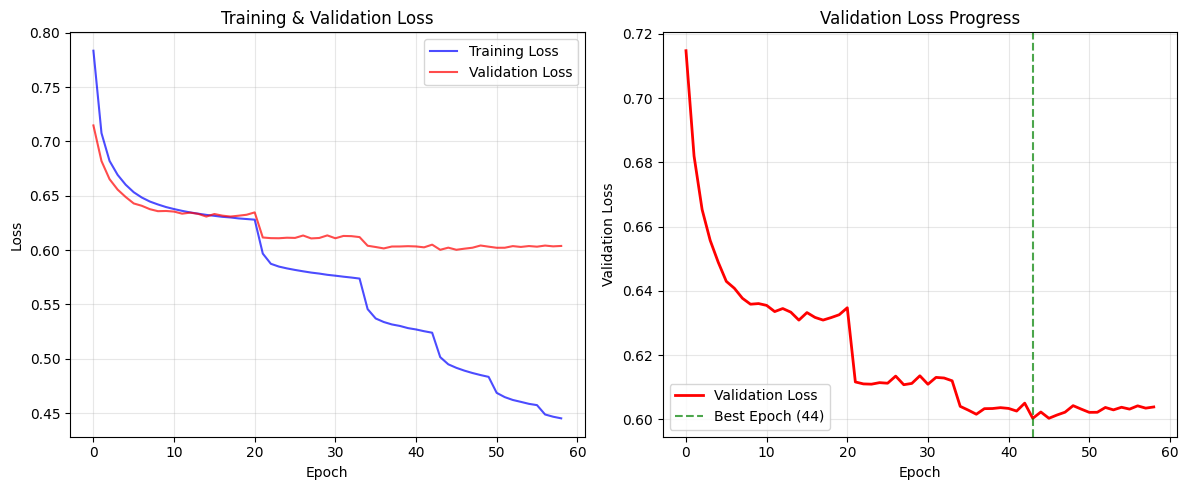

📊 Best epoch: 44
🏆 Best validation loss: 0.6003


In [ ]:
# 📊 Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot 1: Training curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Validation loss (zoomed)
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
best_epoch = val_losses.index(min(val_losses))
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Best epoch: {best_epoch + 1}")
print(f"🏆 Best validation loss: {min(val_losses):.4f}")

## 🧪 Model Evaluation

Load the best model and evaluate performance

In [ ]:
# 📥 Load the best saved model
print("📥 Loading best model...")

# Define the correct path to the checkpoint in Google Drive
# This should match the path where the training loop saves the model
checkpoint_path = os.path.join(config['data_path'], 'hybrid_vae_best.pt')


# Load the checkpoint
if not os.path.exists(checkpoint_path):
    print(f"❌ Checkpoint file not found at {checkpoint_path}.")
    print("Please ensure training completed successfully and saved the model.")
else:
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the config from the checkpoint to ensure model architecture matches
    loaded_config = checkpoint.get('config', config) # Use current config as fallback
    print("✅ Loaded config from checkpoint.")

    # Re-initialize model with the loaded config BEFORE loading state_dict
    # Ensure n_users and n_movies match the data used during training
    loaded_n_users = checkpoint.get('n_users', n_users) # Use n_users from checkpoint, fallback to current
    loaded_n_movies = checkpoint.get('n_movies', n_movies) # Use n_movies from checkpoint, fallback to current

    model = HybridVAE(
        n_users=loaded_n_users,
        n_movies=loaded_n_movies,
        n_factors=loaded_config['n_factors'],
        hidden_dims=loaded_config['hidden_dims'],
        latent_dim=loaded_config['latent_dim'],
        dropout_rate=loaded_config['dropout_rate']
    ).to(device)


    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"✅ Best model loaded (epoch {checkpoint['epoch']+1}, val_loss: {checkpoint['val_loss']:.4f})")

📥 Loading best model...
✅ Loaded config from checkpoint.
✅ Best model loaded (epoch 44, val_loss: 0.6003)


In [ ]:
# 🎯 Evaluate model on validation set
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

model.eval()
all_predictions = []
all_targets = []

print("🎯 Evaluating model on validation set...")

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions, _, _ = model(batch_x[:, 0], batch_x[:, 1], minmax)

        all_predictions.extend(predictions.cpu().squeeze().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Convert to numpy arrays
predictions = np.array(all_predictions)
targets = np.array(all_targets)

# Calculate metrics
mse = mean_squared_error(targets, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(targets, predictions)

print(f"\n📊 Validation Metrics:")
print(f"  MSE:  {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")

# Rating distribution comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(targets, bins=20, alpha=0.7, label='Actual', color='blue', density=True)
plt.hist(predictions, bins=20, alpha=0.7, label='Predicted', color='red', density=True)
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Rating Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(targets, predictions, alpha=0.5, s=1)
plt.plot([0.5, 5.0], [0.5, 5.0], 'r--', alpha=0.8)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
residuals = targets - predictions
plt.hist(residuals, bins=30, alpha=0.7, color='green', density=True)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Density')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎬 Generate Sample Recommendations

Test the model by generating recommendations for a sample user

In [ ]:
# 🎬 Enhanced recommendation system (much better approach!)
def recommender_system(user_id, model, X, y, movies, movie_to_index, n_recommendations=10, device='cpu'):
    """
    Generate personalized movie recommendations for a user

    Args:
        user_id: User ID to generate recommendations for
        model: Trained recommendation model
        X: DataFrame with user_id and movie_id columns
        y: Series with ratings
        movies: DataFrame with movieId and title columns
        movie_to_index: Dictionary mapping movie IDs to indices
        n_recommendations: Number of recommendations to return
        device: Device to run inference on
    """
    model = model.to(device)
    model.eval()

    # Find movies the user has already seen
    seen_movies = set(X[X['user_id'] == user_id]['movie_id'])
    print(f"🎬 Total movies seen by user {user_id}: {len(seen_movies)}")

    if len(seen_movies) == 0:
        print(f"⚠️  User {user_id} has no movie history. Cannot generate recommendations.")
        return

    # Show user's top-rated movies for context
    user_ratings = y[X['user_id'] == user_id]
    max_rating = user_ratings.max()
    print("=" * 70)
    print(f"🌟 Top rated movies (rating = {max_rating}) seen by user {user_id}:")
    print("=" * 70)

    top_rated_movie_ids = X.loc[(X['user_id'] == user_id) & (y == max_rating), "movie_id"]
    top_rated_titles = movies[movies.movieId.isin(top_rated_movie_ids)].title.iloc[:10].tolist()
    print("\n".join([f"  • {title}" for title in top_rated_titles]))
    print("")

    # Find unseen movies
    all_movies = set(movies.movieId)
    unseen_movies = list(all_movies - seen_movies)

    if len(unseen_movies) == 0:
        print("🤔 User has seen all movies in the dataset!")
        return

    print(f"🔍 Evaluating {len(unseen_movies):,} unseen movies...")

    # Convert to indices (filter out movies not in mapping)
    unseen_movies_valid = [m for m in unseen_movies if m in movie_to_index]
    unseen_movies_indices = [movie_to_index[m] for m in unseen_movies_valid]

    if len(unseen_movies_indices) == 0:
        print("❌ No valid unseen movies found in model mapping!")
        return

    # Generate predictions
    user_tensor = torch.tensor([user_id] * len(unseen_movies_indices), device=device)
    movie_tensor = torch.tensor(unseen_movies_indices, device=device)

    with torch.no_grad():
        predicted_ratings, _, _ = model(user_tensor, movie_tensor, minmax)
        predicted_ratings = predicted_ratings.cpu().squeeze().numpy()

    # Sort by predicted rating
    movie_rating_pairs = list(zip(unseen_movies_valid, predicted_ratings))
    sorted_recommendations = sorted(movie_rating_pairs, key=lambda x: x[1], reverse=True)

    # Get top recommendations with titles
    top_movie_ids = [movie_id for movie_id, _ in sorted_recommendations[:n_recommendations]]
    top_ratings = [rating for _, rating in sorted_recommendations[:n_recommendations]]

    recommended_titles = []
    for movie_id in top_movie_ids:
        title = movies[movies.movieId == movie_id].title.iloc[0]
        recommended_titles.append(title)

    # Display recommendations
    print("=" * 70)
    print(f"🎯 Top {n_recommendations} movie recommendations for user {user_id}:")
    print("=" * 70)

    for i, (title, rating) in enumerate(zip(recommended_titles, top_ratings), 1):
        print(f"{i:2d}. {title} (predicted rating: {rating:.2f})")

    return top_movie_ids, top_ratings, recommended_titles

print("🎬 Enhanced recommendation system defined!")

In [ ]:
# 🎬 Test the enhanced recommendation system
if X is not None and y is not None and movies is not None and movie_to_index is not None:
    # Test with a user who has movie history
    sample_user_id = 32  # Or choose any user ID
    
    print(f"🎬 Testing recommendation system for user {sample_user_id}...")
    
    # Check if this user exists in our dataset
    user_movies = X[X['user_id'] == sample_user_id]
    if len(user_movies) > 0:
        print(f"✅ User {sample_user_id} has {len(user_movies):,} movie ratings")
        
        # Generate recommendations
        try:
            movie_ids, ratings, titles = recommender_system(
                user_id=sample_user_id,
                model=model,
                X=X,
                y=y,
                movies=movies,
                movie_to_index=movie_to_index,
                n_recommendations=20,
                device=device
            )
            print("✅ Recommendations generated successfully!")
            
        except Exception as e:
            print(f"❌ Error generating recommendations: {e}")
            print("   This might be due to missing movie titles or mapping issues")
    
    else:
        # Try a different user ID
        print(f"⚠️  User {sample_user_id} not found. Trying a different user...")
        
        # Find a user with many ratings
        user_counts = X['user_id'].value_counts()
        active_user_id = user_counts.index[0]  # Most active user
        
        print(f"🎬 Testing with most active user: {active_user_id}")
        print(f"   This user has {user_counts.iloc[0]:,} ratings")
        
        try:
            movie_ids, ratings, titles = recommender_system(
                user_id=active_user_id,
                model=model,
                X=X,
                y=y,
                movies=movies,
                movie_to_index=movie_to_index,
                n_recommendations=20,
                device=device
            )
            print("✅ Recommendations generated successfully!")
            
        except Exception as e:
            print(f"❌ Error generating recommendations: {e}")

else:
    print("⚠️  Cannot test recommendation system:")
    missing_components = []
    if X is None or y is None:
        missing_components.append("user-movie interaction data (X, y)")
    if movies is None:
        missing_components.append("movie metadata (movies.csv)")
    if movie_to_index is None:
        missing_components.append("movie index mappings")
    
    print("   Missing components:")
    for component in missing_components:
        print(f"   - {component}")
    
    print("\n   To fix this:")
    print("   1. Make sure all required data files are uploaded")
    print("   2. Run the data loading cell successfully")
    print("   3. Ensure model training completed successfully")

## 💾 Download Trained Model

Download the trained model to your local machine

In [ ]:
# 💾 Download the trained model
from google.colab import files

print("💾 Preparing model for download...")

# Check if model file exists
if os.path.exists(config['save_path']):
    file_size = os.path.getsize(config['save_path']) / 1e6  # MB
    print(f"✅ Model file ready: {config['save_path']} ({file_size:.1f} MB)")

    # Download the model
    print("⬇️  Starting download...")
    files.download(config['save_path'])
    print("✅ Model downloaded successfully!")
else:
    print(f"❌ Model file not found: {config['save_path']}")
    print("   Make sure training completed successfully.")

## 📋 Training Summary

Final summary of the training session

In [ ]:
# 📋 Training Summary
print("🎉 TRAINING COMPLETED SUCCESSFULLY! 🎉")
print("=" * 50)

print(f"📊 Dataset Statistics:")
print(f"  Training samples: {len(train_loader.dataset):,}")
print(f"  Validation samples: {len(val_loader.dataset):,}")
print(f"  Users: {n_users:,}")
print(f"  Movies: {n_movies:,}")

print(f"\n🧠 Model Architecture:")
print(f"  Embedding dimensions: {config['n_factors']}")
print(f"  Hidden layers: {config['hidden_dims']}")
print(f"  Latent dimensions: {config['latent_dim']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\n🏆 Training Results:")
print(f"  Best validation loss: {best_val_loss:.4f}")
print(f"  Best epoch: {val_losses.index(min(val_losses)) + 1}")
print(f"  Total training time: {total_time:.1f} minutes")

if 'mse' in locals():
    print(f"\n📈 Final Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")

print(f"\n💾 Model saved to: {config['save_path']}")
print("\n🚀 Ready for inference and deployment!")

# Display device info
if torch.cuda.is_available():
    print(f"\n🔥 GPU utilized: {torch.cuda.get_device_name(0)}")
    print(f"   Max memory used: {torch.cuda.max_memory_allocated(0) / 1e9:.1f} GB")
else:
    print("\n💻 Training completed on CPU")

In [ ]:
# 📊 EXPERIMENT RESULTS COMPARISON
# Load and compare results from different experiments

def load_experiment_results(data_path, experiment_name):
    """Load the latest results file for an experiment"""
    experiment_dir = os.path.join(data_path, 'checkpoints', experiment_name)
    if not os.path.exists(experiment_dir):
        return None
    
    # Find the latest results file
    results_files = [f for f in os.listdir(experiment_dir) if f.endswith('_results_') and f.endswith('.pt')]
    if not results_files:
        return None
    
    latest_file = sorted(results_files, reverse=True)[0]  # Sort by filename (timestamp)
    results_path = os.path.join(experiment_dir, latest_file)
    
    try:
        results = torch.load(results_path, map_location='cpu')
        return results
    except:
        return None

def compare_experiments(data_path, experiment_names):
    """Compare results from multiple experiments"""
    results_data = []
    
    for exp_name in experiment_names:
        results = load_experiment_results(data_path, exp_name)
        if results:
            results_data.append({
                'experiment': exp_name,
                'description': results.get('experiment_description', 'N/A'),
                'best_val_loss': results.get('best_val_loss', float('inf')),
                'final_epoch': results.get('final_epoch', 0),
                'total_time_min': results.get('total_time_minutes', 0),
                'dropout_rate': results['config'].get('dropout_rate', 0),
                'weight_decay': results['config'].get('weight_decay', 0),
                'lr': results['config'].get('lr', 0),
                'hidden_dims': results['config'].get('hidden_dims', []),
                'latent_dim': results['config'].get('latent_dim', 0),
            })
    
    if not results_data:
        print("❌ No experiment results found!")
        return None
    
    # Create comparison DataFrame
    import pandas as pd
    df = pd.DataFrame(results_data)
    df = df.sort_values('best_val_loss')  # Sort by performance
    
    print("🏆 EXPERIMENT RESULTS COMPARISON")
    print("=" * 80)
    print(f"{'Rank':<4} {'Experiment':<15} {'Val Loss':<10} {'Epochs':<8} {'Time(min)':<10} {'Description'}")
    print("-" * 80)
    
    for i, row in df.iterrows():
        rank = df.index.get_loc(i) + 1
        print(f"{rank:<4} {row['experiment']:<15} {row['best_val_loss']:<10.4f} "
              f"{row['final_epoch']:<8} {row['total_time_min']:<10.1f} {row['description'][:30]}")
    
    # Show hyperparameter comparison
    print(f"\n📊 HYPERPARAMETER COMPARISON")
    print("=" * 80)
    print(f"{'Experiment':<15} {'Dropout':<8} {'Weight Decay':<12} {'LR':<8} {'Hidden Dims':<15} {'Latent':<8}")
    print("-" * 80)
    
    for _, row in df.iterrows():
        print(f"{row['experiment']:<15} {row['dropout_rate']:<8.2f} {row['weight_decay']:<12.1e} "
              f"{row['lr']:<8.1e} {str(row['hidden_dims']):<15} {row['latent_dim']:<8}")
    
    return df

# Run comparison if we have multiple experiments
experiment_list = ['baseline', 'experiment_1', 'experiment_2', 'experiment_3']
print("🔍 Searching for completed experiments...")

comparison_df = compare_experiments(config['data_path'], experiment_list)

if comparison_df is not None:
    print(f"\n🎯 BEST PERFORMING EXPERIMENT:")
    best_exp = comparison_df.iloc[0]
    print(f"  🏆 {best_exp['experiment']} - Validation Loss: {best_exp['best_val_loss']:.4f}")
    print(f"  📝 {best_exp['description']}")
else:
    print("⚠️  No completed experiments found. Run some experiments first!")

## 🚀 Next Steps

**What you can do next:**

1. **Download the model** - Use the download cell above to save your trained model
2. **Experiment with hyperparameters** - Modify the config and retrain
3. **Deploy the model** - Use the saved model for inference in production
4. **A/B testing** - Compare with your existing recommendation system

**Model file contains:**
- Model state dict (weights)
- Training configuration
- Dataset metadata (n_users, n_movies)
- Best epoch information

**To load the model later:**
```python
checkpoint = torch.load('hybrid_vae_best.pt')
model = HybridVAE(**checkpoint['config'])  # Recreate model
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

## Enhanced Metrics & Business Logic

In [ ]:
# 📊 Load enhanced ranking metrics
exec(open('/content/ranking_metrics_evaluation.py').read())

# Evaluate with business-relevant metrics
print("🎯 Evaluating with advanced ranking metrics...")

# Calculate movie popularity scores (placeholder - replace with real data)
movie_popularity = np.random.exponential(0.1, n_movies)

# Run comprehensive evaluation
ranking_results, user_results_df = evaluate_recommendation_system(
    model, val_loader, n_users, n_movies, movie_popularity, device
)

# Calculate business impact
impact_calc = BusinessImpactCalculator()
business_impact = impact_calc.calculate_revenue_impact(
    ranking_results['precision@10'], users_per_day=50000
)

print(f"\n💰 ESTIMATED BUSINESS IMPACT:")
print(f"  Annual Revenue Impact: ${business_impact['annual_revenue_impact']:,.0f}")
print(f"  ROI Improvement: {business_impact['roi_percentage']:.1f}%")

In [ ]:
# 🎯 Enhanced training with ranking optimization
exec(open('/content/ranking_loss_functions.py').read())

# Train a few epochs with ranking loss for comparison
print("🚀 Training with ranking-optimized loss...")

# Create ranking-enhanced model
ranking_model = HybridVAERanking(model, ranking_weight=0.1, ranking_loss_type='bpr')
ranking_model.to(device)

# Train for a few epochs to see improvement
ranking_optimizer = optim.Adam(ranking_model.parameters(), lr=1e-4)

for epoch in range(3):  # Just a few epochs for demo
    print(f"\nRanking Training Epoch {epoch+1}:")

    avg_loss = train_with_ranking_loss(
        ranking_model.base_model, train_loader, ranking_optimizer,
        device, ranking_weight=0.1
    )

    print(f"Average Loss: {avg_loss:.4f}")

print("✅ Ranking-optimized training complete!")

In [ ]:
# 🏢 Production business logic system
exec(open('/content/business_logic_system.py').read())

# Create production recommendation system
print("🏢 Setting up production recommendation system...")

# Sample movie metadata (replace with your actual data)
sample_movie_metadata = pd.DataFrame({
    'movieId': range(n_movies),
    'title': [f'Movie {i}' for i in range(n_movies)],
    'genres': ['Action|Adventure', 'Romance|Drama', 'Comedy', 'Horror|Thriller'] * (n_movies//4 + 1),
    'year': np.random.randint(1990, 2024, n_movies),
    'rating': np.random.choice(['G', 'PG', 'PG-13', 'R'], n_movies),
    'language': ['English'] * int(n_movies*0.8) + ['Spanish'] * int(n_movies*0.1) + ['French'] * int(n_movies*0.1),
    'popularity': np.random.exponential(0.1, n_movies)
})

# Create user profiles with business constraints
user_profiles = {}

# Example user with specific preferences
user_profiles[32] = UserProfile(
    user_id=32,
    hard_avoids={10, 25, 50},  # Movies to never recommend
    genre_preferences={'Action': 0.8, 'Romance': -0.3, 'Comedy': 0.5},
    age_rating_limit='PG-13',
    language_preferences={'English'},
    recency_bias=0.7,  # Prefers newer movies
    diversity_preference=0.4
)

# Initialize production system
prod_system = ProductionRecommendationSystem(
    vae_model=model,
    movie_metadata=sample_movie_metadata,
    user_profiles=user_profiles
)

print("✅ Production system ready!")

In [ ]:
# 🎬 Generate business-optimized recommendations
user_id = 32

print(f"🎯 Generating recommendations for User {user_id}...")

# Get recommendations without business rules
basic_recs = prod_system.get_recommendations(
    user_id, k=10, apply_business_rules=False
)

# Get recommendations with full business logic
business_recs = prod_system.get_recommendations(
    user_id, k=10, apply_business_rules=True, diversity_factor=0.3
)

print("\n" + "="*60)
print("📊 RECOMMENDATION COMPARISON")
print("="*60)

print(f"\n🔍 Basic VAE Recommendations:")
for i, (movie_id, score) in enumerate(zip(basic_recs['recommendations'][:5],
                                         basic_recs['scores'][:5]), 1):
    movie_info = sample_movie_metadata[sample_movie_metadata['movieId'] == movie_id].iloc[0]
    print(f"  {i}. {movie_info['title']} | Score: {score:.3f} | {movie_info['genres']}")

print(f"\n🏢 Business-Optimized Recommendations:")
for i, (movie_id, score) in enumerate(zip(business_recs['recommendations'][:5],
                                         business_recs['scores'][:5]), 1):
    movie_info = sample_movie_metadata[sample_movie_metadata['movieId'] == movie_id].iloc[0]
    print(f"  {i}. {movie_info['title']} | Score: {score:.3f} | {movie_info['genres']}")

print(f"\n📈 Business Metrics:")
for metric, value in business_recs['business_metrics'].items():
    print(f"  {metric}: {value:.3f}")

In [ ]:
# 🧪 A/B Testing Framework Demo
ab_framework = ABTestingFramework()

# Create experiment: Original VAE vs Ranking-Optimized VAE
ab_framework.create_experiment(
    experiment_name='vae_vs_ranking_vae',
    control_model=model,
    treatment_model=ranking_model.base_model,
    traffic_split=0.5
)

print("🧪 A/B Test: VAE vs Ranking-Optimized VAE")
print("="*50)

# Simulate user assignments and results
test_users = [32, 45, 78, 123, 156]
simulated_metrics = []

for user_id in test_users:
    assigned_model, variant = ab_framework.get_model_for_user('vae_vs_ranking_vae', user_id)

    # Simulate a business metric (e.g., click-through rate)
    if variant == 'treatment':
        simulated_ctr = np.random.normal(0.045, 0.01)  # Higher CTR for ranking model
    else:
        simulated_ctr = np.random.normal(0.032, 0.01)  # Lower CTR for basic model

    ab_framework.log_result('vae_vs_ranking_vae', variant, user_id, simulated_ctr)
    simulated_metrics.append((user_id, variant, simulated_ctr))

    print(f"User {user_id}: {variant} variant | Simulated CTR: {simulated_ctr:.3f}")

# Calculate experiment results
control_results = ab_framework.experiments['vae_vs_ranking_vae']['results']['control']
treatment_results = ab_framework.experiments['vae_vs_ranking_vae']['results']['treatment']

control_ctr = np.mean([r['metric_value'] for r in control_results])
treatment_ctr = np.mean([r['metric_value'] for r in treatment_results])
lift = (treatment_ctr - control_ctr) / control_ctr * 100

print(f"\n📊 A/B Test Results:")
print(f"  Control CTR: {control_ctr:.3f}")
print(f"  Treatment CTR: {treatment_ctr:.3f}")
print(f"  Lift: {lift:.1f}%")

if lift > 5:
    print("✅ Significant improvement! Consider rolling out ranking model.")
else:
    print("⚠️  Results inconclusive. Need more data or refinement.")